In [1]:
import os 

In [2]:
data = "datas\\names.txt" 
data_path = os.path.join(os.getcwd(),data)

In [3]:
text_data = open(data_path,"r").read().splitlines()
type(text_data)

list

In [4]:
chars   = sorted(list(set("".join(text_data))))
stoi    = {s:i+1 for i,s in enumerate(chars)} 
stoi["."] = 0
itos    = {s:i for i,s in sorted((stoi.items()))}

In [5]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt 

## Build dataset

In [6]:
def build_dataset(dataset:list=None,block_size:int=3):

    X,Y = [],[]
    for word in dataset:

        context = [0] * block_size
        for char in word +".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # crop and append
    
    X = torch.tensor(X,device="cuda")
    Y = torch.tensor(Y,device="cuda") 
    print(X.shape,Y.shape)
    return X,Y


random.seed(42)
random.shuffle(text_data,random=random.seed(42))
n1 = int(0.8 * len(text_data))
n2 = int(0.9 * len(text_data))

x_train,y_train = build_dataset(text_data[:n1])
x_val,y_val     = build_dataset(text_data[n1:n2])
x_test,y_test   = build_dataset(text_data[n2:]) 


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Neural Network

In [7]:
n_embd      = 10
n_hidden    = 200
block_size  = 3
vocab_size  = len(itos)


## initialize the parameters 
g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0")
b1          = torch.randn((n_hidden,),                                  generator=g,device="cuda:0")
w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0")
b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") 

parameters = [C,w1,b1,w2,b2]
print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


In [ ]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 75000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())
    

      0/ 100000 :   28.5865
  10000/ 100000 :   4.2312
  20000/ 100000 :   2.4480
  30000/ 100000 :   2.8876
  40000/ 100000 :   2.5231
  50000/ 100000 :   2.8675
  60000/ 100000 :   2.5860
  70000/ 100000 :   2.2914
  80000/ 100000 :   2.4212
  90000/ 100000 :   2.0905


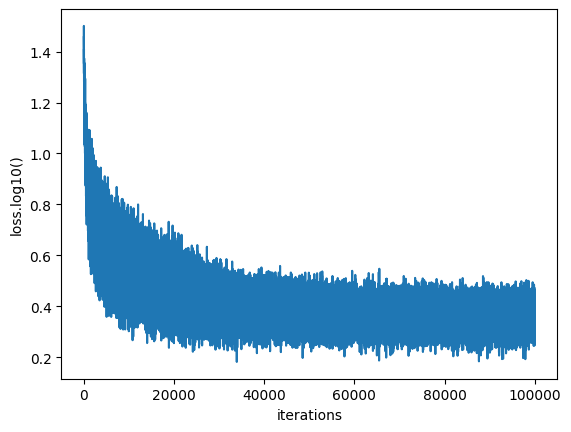

In [ ]:
plt.plot((torch.tensor(loss_i).log10()))
plt.ylabel("loss.log10()")
plt.xlabel("iterations")
plt.show()

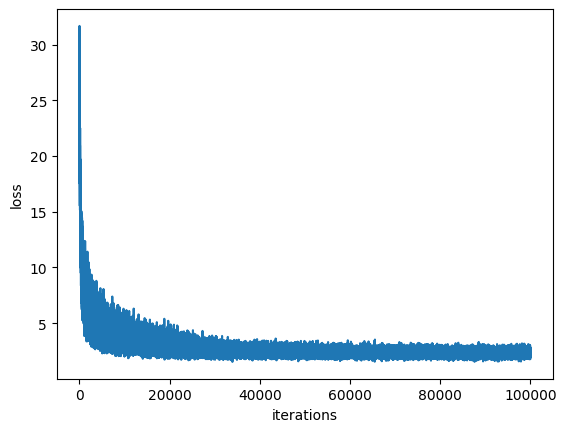

In [ ]:
plt.plot(loss_i)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()

In [ ]:
@torch.no_grad()       # this decorator disable gradient tracking, (no need to calulate during evaluation)
def split_loss(split):
    x,y = {
        "train" : (x_train,y_train),
        "val"   : (x_val,y_val),
        "test"  : (x_test,y_test)
    }[split]
    emb         = C[x]
    emb         = emb.view(emb.shape[0],-1) # (number_of_dataset, block_size * n_emb) (N, 3 * 10)
    h_preact    = emb @ w1 + b1             # (N,200)
    h_act       = torch.tanh(h_preact)      # (N,200)

    logits      = h_act @ w2 + b2           # (N,27)
    loss        = F.cross_entropy(logits,y) 
    print(split,loss.item())

split_loss("train")
split_loss("val")


train 2.31186842918396
val 2.323866844177246


In [ ]:
g = torch.Generator(device="cuda").manual_seed(2147483647 + 10)

for _ in range(25):

    out     = []
    context = [0] * block_size 
    while True:
      emb     = C[torch.tensor([context])] 
      h       = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits  = h @ w2 + b2
      probs   = F.softmax(logits, dim=1)
      ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))
    

bike.
sah.
zem.
deiryn.
jann.
rersheybelidzyomurah.
emi.
rayan.
adgedey.
quif.
mer.
tarelonni.
arstttely.
kedeendy.
marah.
aan.
juilana.
doria.
dareigh.
mabkelliso.
dertericbe.
nico.
mzam.
gie.
reigha.


## Fixing the initial loss 

The loss we get after model training.
- 0/ 200000 :   28.5865
- 25000/ 200000 :   2.6399
- 50000/ 200000 :   2.8675
- 75000/ 200000 :   1.9557
- 100000/ 200000 :   2.1587
- 125000/ 200000 :   2.7489
- 150000/ 200000 :   2.3592
- 175000/ 200000 :   2.4629

We can say that model is improperly configured at initialization. ie, from 1st iteration loss we get is around 28 and rapidly comes out around 1 to 2. Have multiple problems in initialization of model. 

1. Messed up Initialization :    Always have an rough idea for what loss to expect at inialization. At initialization what we have do that probability of each character (number of classes),(27 characters) consider as equal distribution. At initialization we have no reason to believe any characters have more likely than other character. So we expect probability distribution that comes out to be equal/uniform distribution.

    - Probability for any character = (1/27)        = 0.03703
    - Loss                          = -(prob.log()) = 3.2958<br>
- The loss we get by uniform distribution is much lower than what we get from initial initialization. 
- Initialize the parameters roughly zeros,logits do't have to be zeros they just have to be equal. 
    

In [ ]:
## rough output from sample model, 
logits  = torch.tensor([0.1,0.1,0.1,0.1]) 
                                            # probs =  logits / logits.sum()  ======= alternate method of softmax. 
probs   = F.softmax(logits,dim=0)           # we got uniform distribution 0.25 for all data points. 
loss    = -probs[2].log()                   # 
logits,probs,loss


(tensor([0.1000, 0.1000, 0.1000, 0.1000]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [ ]:
## rough output from sample model, 
logits  = torch.tensor([0.1,0.56,0.1,0.1]) 
                                            # probs =  logits / logits.sum()  ======= alternate method of softmax. 
probs   = F.softmax(logits,dim=0)           # we got uniform distribution 0.25 for all data points. 
loss    = -probs[1].log()                   # 
logits,probs,loss


# in this case for, getting 0.56 element from dataset and it's probability is 0.3465.actually 34.56%

(tensor([0.1000, 0.5600, 0.1000, 0.1000]),
 tensor([0.2181, 0.3456, 0.2181, 0.2181]),
 tensor(1.0626))

## Nudge the parameters

In [ ]:
n_embd      = 10
n_hidden    = 200
block_size  = 3
vocab_size  = len(itos)


## initialize the parameters 
g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0")
b1          = torch.randn((n_hidden,),                                  generator=g,device="cuda:0") 
w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0") * 0.01     # fixing the initial loss (logits)
b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") * 0.0      # fixing the initial loss (logits)

parameters = [C,w1,b1,w2,b2]
print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


In [ ]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 75000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())


      0/ 100000 :   3.3238
  10000/ 100000 :   2.6354
  20000/ 100000 :   2.0343
  30000/ 100000 :   2.3747
  40000/ 100000 :   2.1267
  50000/ 100000 :   2.4670
  60000/ 100000 :   2.3716
  70000/ 100000 :   2.2068
  80000/ 100000 :   2.1845
  90000/ 100000 :   2.0451


The logits are getting on 0 th elements are quite extreme values. That why its creating extreme loss value (28). Lets try it to make it logits approximatly/closer to zero. 

## 1. logits = w2 @ h_act + b2. we need to make logits to closer to zero.

- Make the logits closer to zero at initialization 
    - b2 = 0 
    - w2 ~ closer to  zero. scale down w2 by 0.1 all the elements. 
    - By doing that we get loss = 4.28, but we want closer to loss (uniform distribution loss = 3.2958)
    - w2, scale down  by 0.01, ==>> loss we get closer to 3.2958.<br>

    
- Why we can't set w2 = 0 ???
    1. Symmetry Problem in Neural Networks
    
        - Identical Neuron Behavior:
            - Each neuron has weights that are updated during training. If all weights are initialized to zero, all neurons in a layer will compute the same output, leading to identical gradients during backpropagation.
        - No Diversity in Learning:
            - Because the neurons start with identical weights, they will learn the same features and update identically during training. This prevents the network from learning diverse and complex features, limiting its overall capacity and performance.

    2. No Gradient Flow for Zero Initialization

        - Gradient Descent: 
            - In gradient descent, weights are updated based on the gradient of the loss function with respect to the weights. If weights are initialized to zero, the gradients might also be zero for certain activation functions (like ReLU), causing the weights to remain zero, which halts learning altogether.
        - Dead Neurons:
            -  In the case of activation functions like ReLU, if the input to the neuron is zero, the gradient can be zero as well, leading to "dead neurons" that no longer update, further impairing the network's ability to learn.

    3. Bias Term Doesn't Learn Properly

        Bias Needs Flexibility: The bias term in a model helps shift the activation function, allowing the model to fit data better. Initializing weights to zero can prevent the bias from properly influencing the model, leading to a less effective model.

    4. Optimization Difficulty

        Poor Convergence: Zero initialization can lead to poor convergence in optimization algorithms like gradient descent. The weights might either converge very slowly or get stuck in suboptimal points because the gradient provides no meaningful direction to move towards.
        Flat Loss Surface: With zero initialization, the loss surface might become flat, meaning that the model struggles to find gradients that lead to an optimal solution.




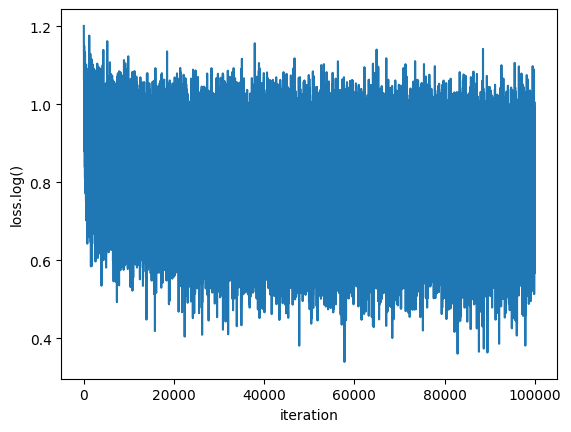

In [ ]:
plt.plot(torch.tensor(loss_i).log())
plt.xlabel("iteration")
plt.ylabel("loss.log()")
plt.show()

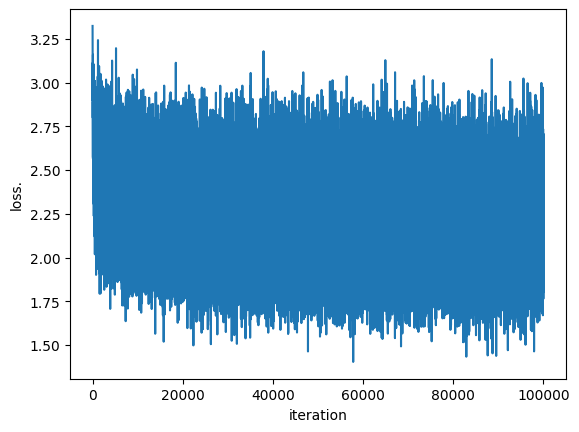

In [ ]:
plt.plot(torch.tensor(loss_i))
plt.xlabel("iteration")
plt.ylabel("loss.")
plt.show()

In [ ]:
split_loss("train")
split_loss("val")

train 2.1788675785064697
val 2.2053844928741455


## 2. Fixing the Saturated Tanh()

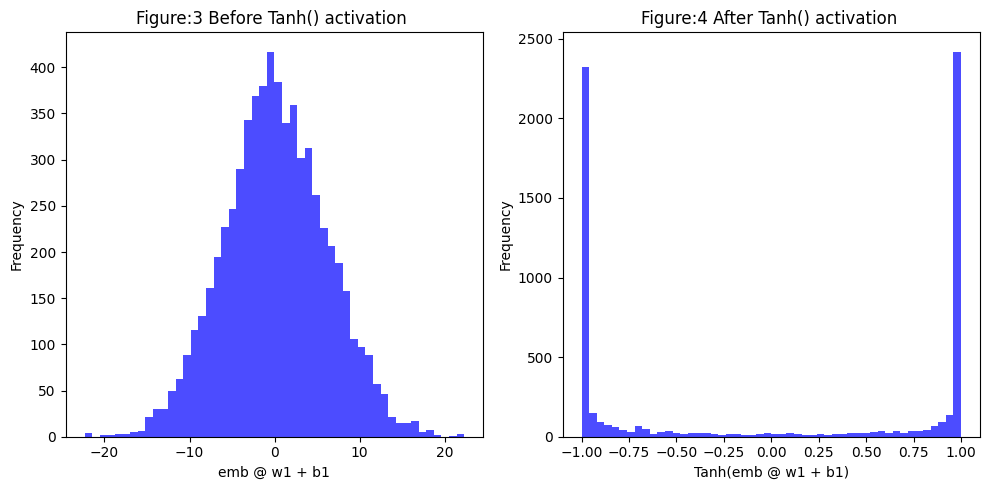

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram
axs[0].hist(h_preact.flatten().tolist(),bins=50, color='blue', alpha=0.7)
axs[0].set_title('Figure:3 Before Tanh() activation ')
axs[0].set_xlabel('emb @ w1 + b1')
axs[0].set_ylabel('Frequency')

# Plot the second histogram
axs[1].hist(h_act.flatten().tolist(),bins=50, color='blue', alpha=0.7)
axs[1].set_title('Figure:4 After Tanh() activation ')
axs[1].set_xlabel('Tanh(emb @ w1 + b1)')
axs[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

From the graph we can see Tanh() funciton is strong,ie (value -1 and 1)
```def tanh(self.data):
    x = data
    t = math.exp(2x) - 1 / math.exp(2x) + 1 
    out = Value(t,(self,)"tanh")
    
    def _backward():
        self.grad += (1 - t**2) * out.grad```


1. case 1 : if we get tanh(x) = 1
    self.grad +=  (1 - 1**2 ) * out./grad = 0. 

    Vanishing gradient = In this case the model literally learn nothing. 

2. case 2 : if we get tanh(x) = -1
    self.grad +=  (1 - -1**2 ) * out./grad = 2 * out.grad.     

    gradient explosion = In this case the model cannot learn nothing over the deap of NN layers. 


In the both end of Tanh() value, we have no control over it, because when ever we want to change the parameters , it doesn't have any impact on loss. 

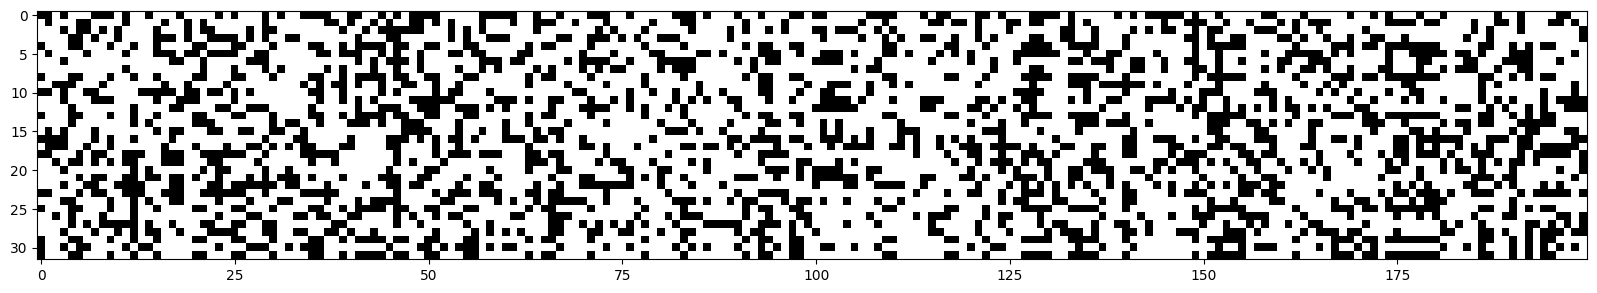

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h_act.cpu().detach().abs()>0.99,cmap="gray",interpolation="nearest");

This above graph representing True False statement. The graph representing relationship between neurons (200) and datas (32). The black representing False and white representing white one. 

- White - all the tanh neurons are highly active (flat tail),**(highly active means closer to 1)** In all these point we get gradient would be destroyed.
    - If the all column in perticular neuron is white it's meaning that the neuron is dead. (neuron where initialization of **w and b** never ever bought into activate). 


- Note: if gradient is zero, that means the neuron is dead. IF no datas ever activates its neuron, so neuron remain forever (permanent brain damage )

![](https://www.oreilly.com/api/v2/epubs/9781788472173/files/assets/7f566009-af69-4eea-b244-014c5fc4fc19.png)


In [ ]:
def find_dead_neuron(threshold:float=0.99,dead_neuron_percentage:float=0.75):
    above_threshold             = h_act > threshold
    percentage_above_threshold  = torch.mean(above_threshold.float(),dim=0)
    #Check if any neuron has dead_neuron % or more of its outputs above 0.99
    threshold_check = percentage_above_threshold >= dead_neuron_percentage
    if torch.any(threshold_check):
        print(f"At least one neuron has {dead_neuron_percentage}% or more of its outputs above {threshold}.")
    else:
        print(f"No neuron has {dead_neuron_percentage}% or more of its outputs above {threshold}.")

    # Optionally, get the indices of neurons that satisfy this condition
    neuron_indices = torch.nonzero(threshold_check).squeeze()
    print("Dead neuron indices:", neuron_indices.tolist())

In [ ]:
find_dead_neuron()

At least one neuron has 0.75% or more of its outputs above 0.99.
Dead neuron indices: [10, 85, 87, 99, 119, 142, 193]


In [ ]:
n_embd      = 10
n_hidden    = 200
block_size  = 3
vocab_size  = len(itos)


## initialize the parameters 
g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0") * 0.1      # fixing the saturated tanh()
b1          = torch.randn((n_hidden,),                                  generator=g,device="cuda:0") * 0.01     # fixing the saturated tanh()
w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0") * 0.01     # fixing the initial loss (logits)
b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") * 0.0      # fixing the initial loss (logits)

parameters = [C,w1,b1,w2,b2]
print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


h_preact = emb @ w1 + b1. we need to optimize the parameter w1 and b1 closer to zero. 

In [ ]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 75000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())


      0/ 100000 :   3.3059
  10000/ 100000 :   2.7482
  20000/ 100000 :   2.1210
  30000/ 100000 :   2.3166
  40000/ 100000 :   2.1576
  50000/ 100000 :   2.5422
  60000/ 100000 :   2.3834
  70000/ 100000 :   2.1545
  80000/ 100000 :   2.1989
  90000/ 100000 :   1.9974


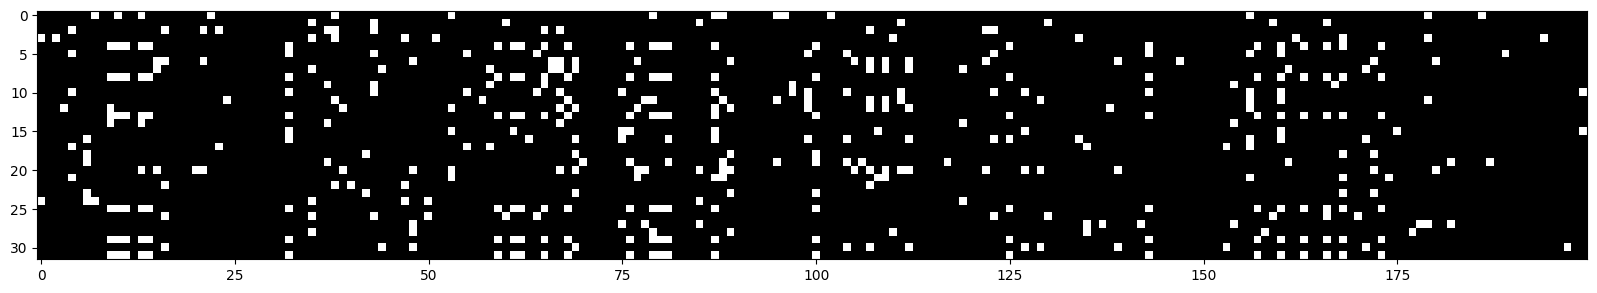

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h_act.cpu().detach().abs()>0.99,cmap="gray",interpolation="nearest");

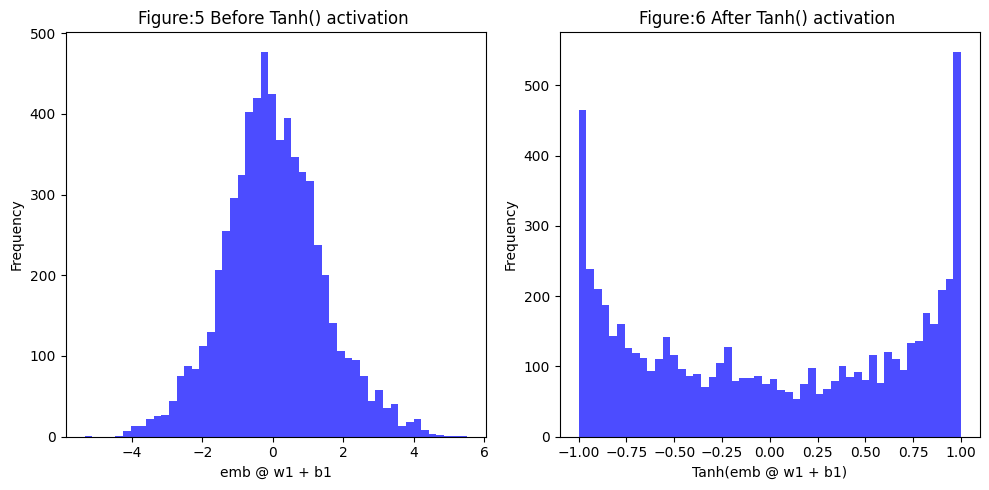

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram
axs[0].hist(h_preact.flatten().tolist(),bins=50, color='blue', alpha=0.7)
axs[0].set_title('Figure:5 Before Tanh() activation ')
axs[0].set_xlabel('emb @ w1 + b1')
axs[0].set_ylabel('Frequency')

# Plot the second histogram
axs[1].hist(h_act.flatten().tolist(),bins=50, color='blue', alpha=0.7)
axs[1].set_title('Figure:6 After Tanh() activation ')
axs[1].set_xlabel('Tanh(emb @ w1 + b1)')
axs[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
find_dead_neuron(dead_neuron_percentage=0.35)

At least one neuron has 0.35% or more of its outputs above 0.99.
Dead neuron indices: 87


In [ ]:
split_loss("train")
split_loss("val")

train 2.1627485752105713
val 2.1801514625549316


## He_Initialization

tensor(0.0034) tensor(1.0058)
tensor(-0.0121) tensor(3.1826)


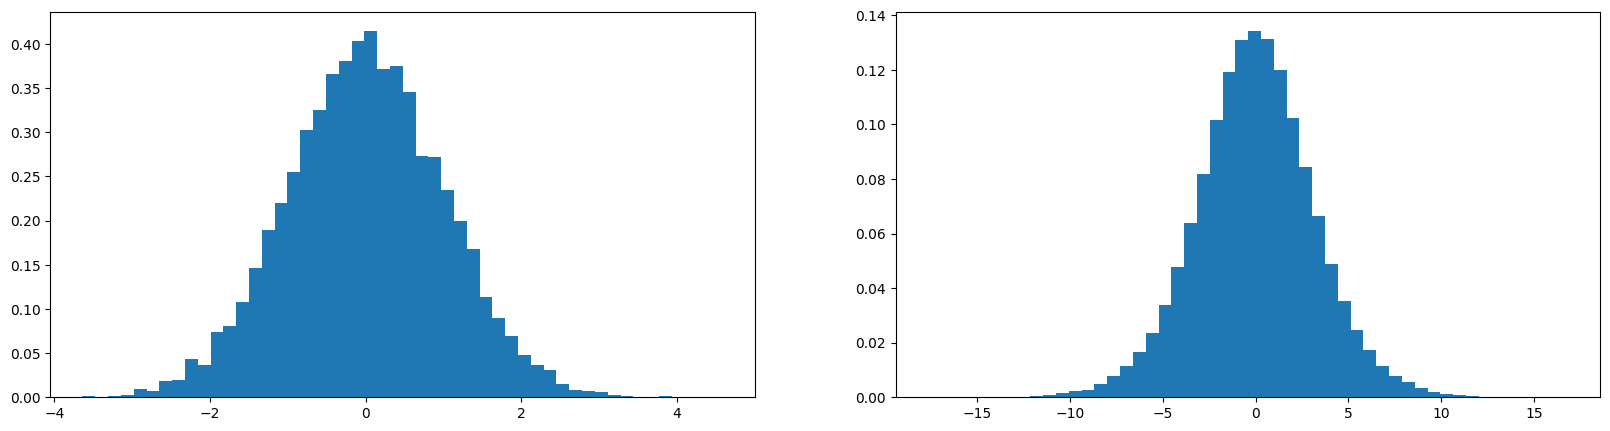

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w 
print(x.mean(),x.std())
print(y.mean(),y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),bins=50,density=True);

plt.subplot(122)
plt.hist(y.view(-1).tolist(),bins=50,density=True);

x - mean is closer to 0 and std is 1. Then we multily this x with w, result = y, the std is greater than 3. in this case we have 3.24. 
- This means that when we multiply x @ w we get closer to same mean but std deviation is entirely changed, std = 3.

#### We don't want to change the charactetrs of distribution ever after the multiplication operation. 

- Most of the neural network has similiar activation, so we need to conserve the normal distribution through out the network. So we need to conserve the weight and bias parameters. 

In [ ]:
x = torch.randn(1000,50)
w = torch.randn(50,200) / 50**0.5   # fan_in = 50, fan_out = 200  ==>> w * 1/ square_root(fan_in) 

y = x @ w 

print(f"before multiplication\nmean : {x.mean()},   std : {x.std()}")
print("\n")
print(f"after multiplication\nmean  : {y.mean()},   std : {y.std()}")


before multiplication
mean : 0.0025479395408183336,   std : 1.002100944519043


after multiplication
mean  : -7.572477625217289e-05,   std : 0.9936976432800293


- For conserving the std of weight parameter, we multiply it with std
    - std = gain / square_root of Fan_in. 
        - Where, Fan_in = number of input.

- Gain value are given in https://pytorch.org/docs/stable/nn.init.html

```nn.init.kaiming_uniform_(w, mode='fan_in', nonlinearity='tanh')```


In [ ]:
# lets find out the std for tanh()
(5/3) / (30)**0.5 # n_embd * block_size = 10 * 3

0.3042903097250923

In [168]:
def initialization_parameters():
    n_embd      = 10
    n_hidden    = 200
    block_size  = 3
    vocab_size  = len(itos)


    ## initialize the parameters 
    g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
    C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
    w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0") * ((5/3)*(n_embd * block_size)**0.5)  # = 0.3042 
    b1          = torch.randn((n_hidden,),                                  generator=g,device="cuda:0") * 0.01
    w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0") * 0.01     # fixing the initial loss (logits)
    b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") * 0.0      # fixing the initial loss (logits)

    parameters = [C,w1,b1,w2,b2]
    
    print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")

    return parameters,C,w1,b1,w2,b2

In [169]:
parameters,C,w1,b1,w2,b2 = initialization_parameters()
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


In [ ]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    h_act       = torch.tanh(h_preact)      # (32,200)

    logits      = h_act @ w2 + b2           # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    #backward pass
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 75000 else 0.01 # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())


      0/ 100000 :   3.3477
  10000/ 100000 :   2.3928
  20000/ 100000 :   2.0058
  30000/ 100000 :   2.3829
  40000/ 100000 :   2.2120
  50000/ 100000 :   2.2568
  60000/ 100000 :   2.3607
  70000/ 100000 :   2.4172
  80000/ 100000 :   2.0026
  90000/ 100000 :   2.2766


In [ ]:
split_loss("train")
split_loss("val")

train 2.8331501483917236
val 2.83701491355896


## Batch Normalization


Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift - https://arxiv.org/pdf/1502.03167

- Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change.
- This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. 
- This is called as **internal covariate shift** 
- To solve this problems we use normalization for each training mini-batch.


In [158]:
parameters,C,w1,b1,w2,b2 = initialization_parameters()

bn_gain = torch.ones(1,n_hidden,device="cuda:0")
bn_bias = torch.zeros(1,n_hidden,device="cuda:0")

parameters.append(bn_gain)
parameters.append(bn_bias)

for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897


In [105]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)
    #batch normalization
    bn_mean_i   = torch.mean(h_preact,dim=0,keepdim=True)
    bn_std_i    = torch.std(h_preact,dim=0,keepdim=True)
    h_preact    = (h_preact - bn_mean_i) / bn_std_i
    h_preact    = bn_gain * h_preact + bn_bias
    h_act       = torch.tanh(h_preact)                  # (32,200)

    logits      = h_act @ w2 + b2                       # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 85000 else 0.01                # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())

      0/ 100000 :   3.3192
  10000/ 100000 :   2.4422
  20000/ 100000 :   2.4432
  30000/ 100000 :   2.1960
  40000/ 100000 :   2.1560
  50000/ 100000 :   2.2372
  60000/ 100000 :   2.2950
  70000/ 100000 :   2.3668
  80000/ 100000 :   2.4734
  90000/ 100000 :   2.2652


- By only doing standadization, we would'nt get any improved result. Because we want these to be roughly gaussian, but **only at initialization**, but we dont want to be forced to be gaussian always. 
- We want to move this around the distribusion, to potentially make it more spread, less spread, sharp (don't want to be always gaussian). 
- So back propagation can be tell us how the distribustion should move around. so that we also include additional components. 

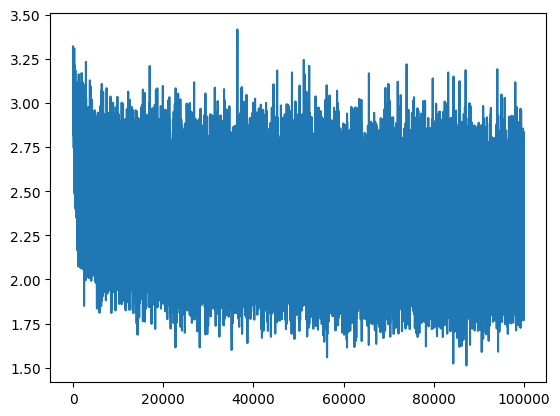

In [109]:
plt.plot(loss_i);

- During the optimization / back propagation network gives full ability to do whatever they want internally. 
- In this case the batch normalization is not much doing anything, because the This model is simple so its have lesser effect. And also before 'BN' we already make the distribution gaussian by other methods like He_initialization, weight initialization, so that BN normalization doesnt give proper result on the training. But for complex NN/deeper NN models BN is capable of better perfomance.<br> 

## Disadvantages 


- For efficiency we traine the model with batches of datas, so the batches of datas were processed independently. 
1. Batch normalization introduces additional complexity to the model by adding extra parameters (scale and shift parameters) and the need to compute mean and variance for each batch during training.

2. Dependence on Batch Size: The performance of batch normalization can be sensitive to the batch size used. Smaller batch sizes may lead to noisier estimates of the batch statistics, which can negatively impact the model's performance.

3. Training-Time Only: The benefits of batch normalization (such as reducing internal covariate shift) are primarily seen during training. During inference, fixed statistics (calculated from the training set) are used, which might not perfectly represent the true distribution of data the model sees during inference.

4. Incompatibility with Certain Architectures: In some cases, such as in recurrent neural networks (RNNs) or with very small batch sizes, batch normalization may not be suitable or may require modifications (e.g., using Layer Normalization instead).

5. Potential for Overfitting: If not used correctly, batch normalization can potentially lead to overfitting, especially when combined with small batch sizes or complex models.


![](https://kharshit.github.io/img/batch_normalization.png)

- Stability offered by Batch normalization actually comes at terible cost. 
- Single data is feed into NN and we calculate this activations and its logits and get logits, for training efficiency of we use batches, and those process independently. 
- Each `h_preact` that feed into hidden layer activations for any data in batch is actually going to change slightly depending on what other data in batch. And output of activation function is Jitter. 

- This effect is really a good in NN trainig- This is act like a `Regularizer`.
    - You have an example (data) and get a `h_act`and depending on other data in batch this going to jitter (noise)     
    - By noise, its difficult to over fit the model, 

### Pass single data into NN 


- Once we train the model we feed single data into model for getting prediction. But how we do this when we calculate the statistics of batch data. 

In [121]:
 # we dont wanna calculate the grad of either mean and std of the entire dataset, that why we use torch.no_grad()

with torch.no_grad():
    emb         = C[x_train]
    emb         = emb.view(emb.shape[0],-1) # (number_of_dataset, block_size * n_emb) (N, 3 * 10)
    h_preact    = emb @ w1 + b1             # (N,200)
    # calculate the mean and std of entire dataset 
    bn_mean     = torch.mean(h_preact,dim=0,keepdim=True)
    bn_std      = torch.std(h_preact,dim=0,keepdim=True)    


In [122]:
@torch.no_grad()       # this decorator disable gradient tracking, (no need to calulate during evaluation)
def split_loss(split):
    x,y = {
        "train" : (x_train,y_train),
        "val"   : (x_val,y_val),
        "test"  : (x_test,y_test)
    }[split]
    emb         = C[x]
    emb         = emb.view(emb.shape[0],-1) # (number_of_dataset, block_size * n_emb) (N, 3 * 10)
    h_preact    = emb @ w1 + b1             # (N,200)
    #batch normalization
    h_preact    = (h_preact - bn_mean) / bn_std
    h_preact    = bn_gain * h_preact + bn_bias
    h_act       = torch.tanh(h_preact)      # (N,200)

    logits      = h_act @ w2 + b2           # (N,27)
    loss        = F.cross_entropy(logits,y) 
    print(split,loss.item())

split_loss("train")
split_loss("val")


train 2.2454428672790527
val 2.251929521560669


The above operation is not efficient, so we need to find the mean and std during the training. 
## We can find the bn_mean and bn_std during the iteration.

In [170]:
# parameters of  the model.
parameters,C,w1,b1,w2,b2 = initialization_parameters()

bn_gain = torch.ones(1,n_hidden,device="cuda:0")
bn_bias = torch.zeros(1,n_hidden,device="cuda:0")
parameters.append(bn_gain)
parameters.append(bn_bias)

# buffer of the model 
bn_mean_running = torch.zeros(1,n_hidden,device="cuda:0")           # why we use mean=0 and std= 1,during the initialization we make it as gaussian data
bn_std_running  = torch.ones(1,n_hidden,device="cuda:0")            # why we use mean=0 and std= 1,during the initialization we make it as gaussian data 

print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11897
total numbers of parameters :   12297


- During the training (updating parameters) `bn_mean_running & bn_std_running` are not part of gradient based optimization. So never derive gradient of both of these duting the training. 
- 

In [171]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 

    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    h_preact    = emb @ w1 + b1             # (32,200)

    #batch normalization
    bn_mean_i   = torch.mean(h_preact,dim=0,keepdim=True)   # finding the batch mean
    bn_std_i    = torch.std(h_preact,dim=0,keepdim=True)    # finding the batch std
    h_preact    = (h_preact - bn_mean_i) / bn_std_i
    h_preact    = bn_gain * h_preact + bn_bias

    # finding mean and std of entire dataset
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running  = 0.999 * bn_std_running  + 0.001 * bn_std_i

    h_act       = torch.tanh(h_preact)                  # (32,200)
    logits      = h_act @ w2 + b2                       # (32,27)
    loss        = F.cross_entropy(logits,y_batch) 
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 85000 else 0.01                # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())

      0/ 100000 :   3.2642
  10000/ 100000 :   2.7036
  20000/ 100000 :   2.2060
  30000/ 100000 :   2.3763
  40000/ 100000 :   2.4879
  50000/ 100000 :   2.3460
  60000/ 100000 :   2.5737
  70000/ 100000 :   2.5552
  80000/ 100000 :   2.1835
  90000/ 100000 :   2.3333


- In this case `bn_mean_running ~= bn_mean` and `bn_std_running ~= bn_std`


In this  above case, we combine 
``` 

with torch.no_grad():
    emb         = C[x_train]
    emb         = emb.view(emb.shape[0],-1) # (number_of_dataset, block_size * n_emb) (N, 3 * 10)
    h_preact    = emb @ w1 + b1             # (N,200)
    # calculate the mean and std of entire dataset 
    bn_mean     = torch.mean(h_preact,dim=0,keepdim=True)
    bn_std      = torch.std(h_preact,dim=0,keepdim=True)    

with training stage. 

In [149]:
bn_std_running[0,1].item(),bn_std[0,1].item()


## look at the result, both are approximately equal. 

(46.713645935058594, 47.30787658691406)

- From the batch normalization we can see a term "Epsilon". Its mainly used for preventing division by 0,

## No need for b1 term

- h_preact = bn_gain * (h_preact - bn_mean_i) / bn_std_i + bn_bias -- This is the equation for batch normalization. 
- `b1` is added with `h_preact = emb * w1 + b1`, this bias is actually useless.
    - calculate the mean (bn_mean_i) is subtracted with h_preact,`h_preact - bn_mean_i`. 
        - whenever bias is add, ie `h_preact    = emb @ w1 + b1` is going to subtracted `h_preact - bn_mean_i` here. so bias not imapact on calculation. 
        - b1.grad = 0.0 
- Batch normalization, better to not use bias(b) before non linear function. 
- Actually bn_bias taking care of calculations rather than bias (b1). Batch normalization has it own bias (bn_bias), and there is no need to have bias (b) in the layer before it. 


In [173]:
def initialization_parameters():
    n_embd      = 10
    n_hidden    = 200
    block_size  = 3
    vocab_size  = len(itos)


    ## initialize the parameters 
    g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
    C           = torch.randn((vocab_size,n_embd),                          generator=g,device="cuda:0")
    w1          = torch.randn((n_embd * block_size,n_hidden),               generator=g,device="cuda:0") * ((5/3)*(n_embd * block_size)**0.5)  # = 0.3042 
    w2          = torch.randn((n_hidden,vocab_size),                        generator=g,device="cuda:0") * 0.01     # fixing the initial loss (logits)
    b2          = torch.randn((vocab_size,),                                generator=g,device="cuda:0") * 0.0      # fixing the initial loss (logits)

    parameters = [C,w1,w2,b2]
    
    print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")

    return parameters,C,w1,w2,b2

##-------------------------------------------------------------------------------------------------------------------------------
parameters,C,w1,w2,b2 = initialization_parameters()

bn_gain = torch.ones(1,n_hidden,device="cuda:0")
bn_bias = torch.zeros(1,n_hidden,device="cuda:0")
parameters.append(bn_gain)
parameters.append(bn_bias)


bn_mean_running = torch.zeros(1,n_hidden,device="cuda:0")           # why we use mean=0 and std= 1,during the initialization we make it as gaussian data
bn_std_running  = torch.ones(1,n_hidden,device="cuda:0")            # why we use mean=0 and std= 1,during the initialization we make it as gaussian data 

print(f"total numbers of parameters :   {sum(para.nelement() for para in parameters)}")
for para in parameters:
    para.requires_grad = True

total numbers of parameters :   11697
total numbers of parameters :   12097


In [174]:
n_iter      = 100000
batch_size  = 32
loss_i      = []

for i in range(n_iter):

    # mini batch
    ix              = torch.randint(0,x_train.shape[0],(batch_size,),generator=g,device="cuda:0") # 32 numbers between 0 to 182437==>> shape (32,)
    x_batch,y_batch = x_train[ix],y_train[ix] 
    # forward pass 
    emb         = C[x_batch]                # (32,3,10)
    emb         = emb.view(emb.shape[0],-1) # (32,30)
    # linear layer 
    h_preact    = emb @ w1 #+ b1             # (32,200)
    # ---------------------------------------------------------------------------------------------------------
    #batch normalization
    # ----------------------------------------------------------------------------------------------------------
    bn_mean_i   = torch.mean(h_preact,dim=0,keepdim=True)   # finding the batch mean
    bn_std_i    = torch.std(h_preact,dim=0,keepdim=True)    # finding the batch std
    h_preact    = (h_preact - bn_mean_i) / bn_std_i
    h_preact    = bn_gain * h_preact + bn_bias
    # finding mean and std of entire dataset
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i   # momemtum = 0.001
        bn_std_running  = 0.999 * bn_std_running  + 0.001 * bn_std_i
    # -----------------------------------------------------------------------------------------------------------
    # Non linear layer 
    h_act       = torch.tanh(h_preact)              # (32,200)  ==>> hidden layer 
    logits      = h_act @ w2 + b2                   # (32,27)   ==>> output layer
    loss        = F.cross_entropy(logits,y_batch)   #           ==>> loss function
    for para in parameters:
        para.grad = None
    loss.backward()
    
    lr = 0.1 if n_iter < 85000 else 0.01                # step learning rate decay 
    for para in parameters:
        para.data += -lr * para.grad
    
    # track loss 
    if i % 10000 == 0:
        print(f"{i:7d}/{n_iter:7d} :   {loss.item():.4f}")
    loss_i.append(loss.item())

      0/ 100000 :   3.2992
  10000/ 100000 :   2.6282
  20000/ 100000 :   2.5567
  30000/ 100000 :   2.2255
  40000/ 100000 :   2.2702
  50000/ 100000 :   2.4597
  60000/ 100000 :   2.3778
  70000/ 100000 :   2.8408
  80000/ 100000 :   1.8680
  90000/ 100000 :   2.3952


In [175]:
split_loss("train")
split_loss("val")

train 2.2448792457580566
val 2.252720594406128


```with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i  
        bn_std_running  = 0.999 * bn_std_running  + 0.001 * bn_std_i
```
#### 0.001 is momentum, 

#### Some times we need to change the momentum value based on the batch size 

- if you have very large size, the mean and std are going to have approximately equal to each other in all batches. 
    - bn_mean_i is going to have  same mean in all batches. 
    - bn_std_i is going to have  same std in all batches. 

    - so value of momentum choos to be higher. 
- if batch size is smaller like 32, the mean and std going to have different values. so we need to settle down the mean and std we choose momentum to lower values like 0.001. 
    - if choose momentum to be smaller like 0.1, then the bn_mean_running would be trashing tooo mush. and doesnt help to converge properly. 

batch normalization link :- https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html


- track_running_stats=True 

     ```
     with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i   
        bn_std_running  = 0.999 * bn_std_running  + 0.001 * bn_std_i```

- track_running_stats=False<br>- track_running_stats is set to False, this layer then does not keep running estimates, and batch statistics are instead used during evaluation time as well.
